# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete have #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [31]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
import math
%matplotlib inline


The following code block contains an 8x8 matrix that will be used as a maze object:

In [32]:
# Create a 8x8 maze with '1's for empty spaces and '0's for occupied (blocked) spaces.
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [33]:
# This function depicts the maze.
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [34]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration Factor (epsilon):
    
""" 
The first epoch starts with this epsilon value. Change the value of this 
variable to adjust the initial epsilon value (before decay begins). 
"""
initial_epsilon = 0.45

""" 
The final epoch starts with this epsilon value. Change the value of this 
variable to adjust the final epsilon value (after decay is complete). 
"""
final_epsilon = 0.01

""" 
This is the rate at which epsilon will decay.  Change the value of this 
variable to adjust the rate of epsilon decay. 
"""
decay_rate = 0.98


""" 
This is the rate at which epsilon will decay for step decay.  Change the 
value of this variable to adjust the rate of epsilon decay 
(does variable only affects step decay). 
"""
decay_interval = 5

# This dictionary contains the agent's potential actions.
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

# The number of actions is the size of the 
# actions_dict dictionary.
num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


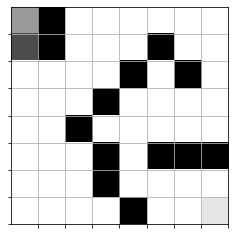

In [35]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [36]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        
        # Get the next action.
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # Apply the action, get the rewards and the new state.
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [37]:
# Check for completion of the maze:

# This function takes in our model and our maze as parameters.
def completion_check(model, qmaze):
    
    # For every free cell,
    for cell in qmaze.free_cells:
        
        # If there are no valid actions, return False.
        if not qmaze.valid_actions(cell):
            return False
        
        # If the game is over, return False.
        if not play_game(model, qmaze, cell):
            return False
    
    # Otherwise, return True.
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [38]:
# This function builds our maze.
def build_model(maze):
    
    # Make our model sequential.
    model = Sequential()
    
    # Add a dense layer.
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    
    # Add a Parametric Rectified Linear Unit activation layer.
    model.add(PReLU())
    
    # Add another dense layer.
    model.add(Dense(maze.size))
    
    # Add another Parametric Rectified Linear Unit activation layer.
    model.add(PReLU())
    
    # Add a final dense layer.
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

### ADDED EPSILON DECAY FUNCTIONS:
 
 These functions offer three choices for the decay of epsillon over time:
- Linear Decay
- Exponential Decay
- Step (or discrete interval) decay

In [39]:
# Decay epsilon linearly from an initial value to a final value over a specified number of epochs:

# This function takes parameters for the initial epsilon value, the final epsilon value, 
# the number of total epochs, and the current epoch number.
def linear_epsilon_decay(initial_epsilon, final_epsilon, total_epochs, current_epoch):
    
    # Try to calculate the new epsilon value with linear decay.
    try:
        return initial_epsilon - (current_epoch / total_epochs) * (initial_epsilon - final_epsilon)
    
    # If calculating the new epsilon value throws a TypeError or ValueError, inform the user 
    # and recommend that they check their parameter, variable, and value data types.
    except (TypeError, ValueError) as e:
        print("Something went wrong while attempting to calculate the linear epsilon decay. ", e)
        print("One or more variable or function parameters is set to an incompatible data type, or the value itself is not of the appropriate type. ", e)
        print("Check that your variables and parameters are of the correct data type. ", e)
    
    # If the calculation of the new epsilon value throws another type of error, then 
    # infom the user that something went wrong while attempting to calculate the 
    # linear epsilon decay.
    except: 
        print("Something went wrong while attempting to calculate the linear epsilon decay. ") 
        

# Decay epsilon exponentially each epoch:
# This function takes parameters for the initial epsilon value, the final epsilon value, 
# and the current epoch.
def exponential_epsilon_decay(initial_epsilon, decay_rate, current_epoch):
    
    # Try to calculate the new epsilon value with exponential decay.
    try:
        return initial_epsilon * (decay_rate ** current_epoch)
    
    # If calculating the new epsilon value throws a TypeError or ValueError, inform the user 
    # and recommend that they check their parameter, variable, and data types.
    except (TypeError, ValueError) as e:
        print("Something went wrong while attempting to calculate the exponential epsilon decay. ", e)
        print("One or more variable or function parameters is set to an incompatible data type, or the value itself is not of the appropriate type. ", e)
        print("Check that your variables and parameters are of the correct data type. ", e)
    
    # If the calculation of the new epsilon value throws another type of error, then 
    # infom the user that something went wrong while attempting to calculate the 
    # exponential epsilon decay.
    except: 
        print("Something went wrong while attempting to calculate the exponential epsilon decay. ") 

# Drop epsillon at a specific interval of epochs (decay_interval):
# This function takes the initial epsilon value, the decay rate, the interval at which 
# epsilon will be decayed (decay_interval), and the current epoch as paramerters.
def step_epsilon_decay(initial_epsilon, decay_rate, decay_interval, current_epoch):
    
    # Try to calculate the new epsilon value with step decay.
    try: 
        return initial_epsilon * (decay_rate ** (current_epoch // decay_interval))
    
    # If calculating the new epsilon value throws a TypeError or ValueError, inform the user 
    # and recommend that they check their parameter and variable data types and values.
    except (TypeError, ValueError) as e:
        print("Something went wrong while attempting to calculate the step epsilon decay. ", e)
        print("One or more variable or function parameters is set to an incompatible data type, or the value itself is not of the appropriate type. ", e)
        print("Check that your variables and parameters are of the correct data type. ", e)
    
   # If the calculation of the new epsilon value throws another type of error, then 
    # infom the user that something went wrong while attempting to calculate step epsilon decay.
    except: 
        print("Something went wrong while attempting to calculate the step epsilon decay. ") 


### ADDED DATA SIZE ADJUSTMENT FUNCTION:

This function adjusts the data size parameter dynamically based on the epoch number. 

In [40]:
# Adjust the data size by periodically decreasing the data size.

# This function takes in the current data size and the epoch number as functions.
def adjust_data_size(data_size, epoch):
    
    # Initialize a new_data_size variable.
    new_data_size = data_size
    
    """ Change the value of this variable to adjust the number of steps at which the data size is decreased. """
    number_of_steps = 7
    
    # If the current epoch number is a multiple of the value of the number_of_steps variable,
    # (if there is no remainder when it is divided by number_of_steps)
    # and the current epoch number is not 0,
    if epoch % number_of_steps == 0 and epoch != 0:
        
        # then, if the data size is greater than 1,
        if data_size > 1:
            
            """ Change the value of this variable to decrease the data size by the desired amount. """
            subtract_by = 2
            
            # set the new data size to the original data size minus the value of the subtract_by variable. 
            new_data_size = data_size - subtract_by
    
    # Otherwise, if the current epoch number is not a multiple of 10,
    else:
        
        # then leave the data size unchanged.
        new_data_size = data_size
        
    # Return the new data size, whether changed or unchanged.
    return new_data_size 

## FUNCTION FOR PRINTING AN EPOCH: 

This function has been taken out of the qtrain function to modularize the function to improve readability, reusability, and maintainability.

In [41]:
# This function prints the results of an epoch.  The function takes the current epoch number
# (epoch), the number of epochs (n_epochs), data size, loss, number of episodes (n_episodes), 
# win history, and win rate as parameters. 
def print_epoch(epoch, n_epoch, epsilon, data_size, loss, n_episodes, win_history, win_rate):
    # start time
    start_time = datetime.datetime.now()
    
    # Try printing the results of an epoch.
    try:
        
        #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Epsilon: {:.4f} | Data Size: {} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {} \n"
        print(template.format(epoch, n_epoch-1, epsilon, data_size, loss, n_episodes, sum(win_history), win_rate, t))
    
    # If the printing of the epoch results throws a TypeError or a ValueError, inform the user
    # and recommend that they check their parameter and variable data types and values.
    except (TypeError, ValueError) as e:
        print("Something went wrong while attempting to print the epoch results.", e)
        print("One or more variable or function parameters is set to an incompatible data type, or the value itself is not of the appropriate type. ", e)
        print("Check that your variables and parameters are of the correct data type. ", e)
    
    # If the printing of epoch results throws another type of error,  inform 
    # the user and recommend that something went wrong while attempting to 
    # print the epoch results.
    except:
        print("Something went wrong while attempting to print the epoch results. ")

## FUNCTION FOR THE TRAINING LOOP:

This function has been taken out of the qtrain function to modularize the function to improve readability, reusability, and maintainability.

In [42]:
# This function executes our training loop.  The function takes the number of epochs (n_epoch), maximum 
# memory, data size, start time, the maze state (qmaze), especience, win history, and win rate parameters.
def training_loop(n_epoch, max_memory, data_size, start_time, qmaze, experience, win_history, hsize, win_rate):
    # For each epoch:
    for epoch in range(n_epoch):
    
        # Set the value of the boolean game_over variable to False initially.
        game_over = False
        
        # Set the number of episodes to zero initially.
        n_episodes = 0
        
        # Set the loss to zero initially.
        loss = 0.0
        
        # Randomly select a free cell for the agent to move to.
        agent_cell = random.choice(qmaze.free_cells)
        
        # Reset the maze with agent set to the previous position.
        qmaze.reset(agent_cell)

        # Use the 'observe()' method to set the envstate variable's value to the new state.
        envstate = qmaze.observe()
        
        # Use one of the three epsilon decay functions to decay epsilon over time:
        """
        The three lines of code below this docstring, including those which 
        are commented out, can be used to call each of our epsilon decay 
        functions.  Uncomment the line of code which represents the appropriate 
        function that uses the type of decay which you would like to use.  
        Only one of these three lines should be uncommented.
        """
        """ Uncomment this line for linear decay. """
        #epsilon = linear_epsilon_decay(initial_epsilon, final_epsilon, n_epoch, epoch)
        
        """ Uncomment this line for exponential decay. """
        epsilon = exponential_epsilon_decay(initial_epsilon, decay_rate, epoch)
        
        """ Uncomment this line for step (discrete interval) decay. """
        #epsilon = step_epsilon_decay(initial_epsilon, decay_rate, decay_interval, epoch)
        
        # Use the adjust_data_size() function to adjust the data size.
        # Pass in the data_size variable and the epoch variable as parameters.
        data_size = adjust_data_size(data_size, epoch)
        
        # While state is not game over:
        while not game_over:
            
            # Get the possible actions (valid actions) which the agent can take
            # in the current state.
            valid_actions = qmaze.valid_actions()
            
            # If the action is not valid, then break.
            if not valid_actions:
                break
            
            # Set the previous endstate to endstate.
            prev_envstate = envstate
            
             # Randomly choose an action (left, right, up, down) either by exploration or by exploitation.
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            
             # The agent acts in consideration of the current game and the reward specifications.
            envstate, reward, game_status = qmaze.act(action)
            
            # If the agent wins, add one to the number of wins and set 'game_over' to True.
            if game_status == 'win':
                win_history.append(1)
                game_over = True
                
            # If the agent loses, do not append another win, and set 'game_over' to True.
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
                
            # If the agent has not won or lost, the game is not over and 'game_over' is set to False.
            else: 
                game_over = False
            
            # Put the values of these variablestogether into an 'episode'.
            episode = [prev_envstate, action, reward, envstate,game_status]
            
            # Add one to the number of episodes.
            n_episodes += 1
            
            # Store episode in an experience replay object.
            experience.remember(episode)
            
            # Call GameExperience.get_data to retrieve training data (input and target).
            inputs,targets = experience.get_data(data_size=data_size)
            
            # Train the neural network model.
            history = model.fit(inputs, targets, epochs=12, batch_size=32, verbose=0)

            # Evaluate the loss. 
            loss = model.evaluate(inputs, targets, verbose=0)
            
        # If the agent wins every game in an epoch, then the win rate is 1.0. 
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        # Print the current epoch using the print_epoch() function, passing in the current
        # epoch number (epoch), number of epochs (n_epoch), exploration factor (epsilon), 
        # data size, loss, number of epusides (n_episodes), win history, and win rate.
        print_epoch(epoch, n_epoch, epsilon, data_size, loss, n_episodes, win_history, win_rate)
        
        
        # Implement an early stopping technique to prevent overfitting 
        # and improve learning efficiency:
        
        # If the win rate reaches 100%,
        if win_rate == 1.0:
            
            # then print the epoch at which a win rate of 100%,
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
                        
            # and exit the program.
            break
    
    # Try to print the final results after training.
    try:
        # Print the final results
        dt = datetime.datetime.now() - start_time
        seconds = dt.total_seconds()
        t = format_time(seconds)
        print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
        return seconds
    
    # If the printing of final results throws a TypeError or a ValueError, inform the user
    # and recommend that they check their parameter, variable, and value data types.
    except (TypeError, ValueError) as e:
        print("Something went wrong while attempting to print the final results. ", e)
        print("One or more variable or function parameters is set to an incompatible data type, or the value itself is not of the appropriate type. ", e)
        print("Check that your variables and parameters are of the correct data type. ", e)
    
    # If the printing of final results throws another type of error, then 
    # infom the user that something went wrong while attempting to print
    # the final results.
    except: 
        print("Something went wrong while attempting to print the final results. ")

# Q-Training Algorithm Code Block

This is the deep Q-learning implementation. The goal of our deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. 

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [43]:
# This function trains our model.  The function takes in the model and maze as parameters, and 
# collects any extra keyword arguments passed to the function into opt. 
def qtrain(model, maze, **opt):
    
    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct the game environment from a numpy array: maze.
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    # history of win/lose game
    win_history = []   
    
    # history window size
    hsize = qmaze.maze.size//2   
    win_rate = 0.0

    training_loop(n_epoch, max_memory, data_size, start_time, qmaze, experience, win_history, hsize, win_rate)

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)
    


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

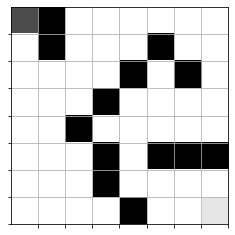

In [44]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [45]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Epsilon: 0.4500 | Data Size: 32 | Loss: 0.0109 | Episodes: 163 | Win count: 1 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 001/14999 | Epsilon: 0.4410 | Data Size: 32 | Loss: 0.0014 | Episodes: 10 | Win count: 2 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 002/14999 | Epsilon: 0.4322 | Data Size: 32 | Loss: 0.0015 | Episodes: 140 | Win count: 3 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 003/14999 | Epsilon: 0.4235 | Data Size: 32 | Loss: 0.0012 | Episodes: 83 | Win count: 4 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 004/14999 | Epsilon: 0.4151 | Data Size: 32 | Loss: 0.0006 | Episodes: 10 | Win count: 5 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 005/14999 | Epsilon: 0.4068 | Data Size: 32 | Loss: 0.0009 | Episodes: 1 | Win count: 6 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 006/14999 | Epsilon: 0.3986 | Data Size: 32 | Loss: 0.0022 | Episodes: 92 | Win count: 7 | Win rate: 0.000 | time: 0.0 seconds 

Epoch: 007/14999 | Epsilon: 0.3907 | Data Size:

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

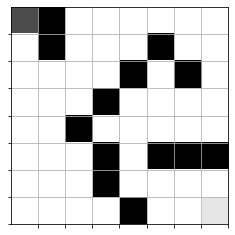

In [46]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

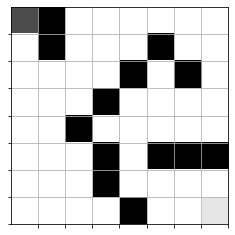

In [47]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.